In [ ]:
!pip install -U sacrebleu datasets transformers sentencepiece protobuf accelerate matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 83.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 113.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━

In [ ]:
from datasets import Dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup

In [ ]:
# Load dataset with pandas
file_path = 'highly_aligned_df.csv'  
df = pd.read_csv(file_path)
df = df.sample(frac=1, random_state=42)

In [ ]:
df

,Unnamed: 0,hr,nl
928069,928069,"12 , mikro pisač , termički čini ispis ljepšim...","12 , microprinter , thermisch maakt afdrukken ..."
358262,358262,4 pretinca bukva čaj okvir dobavljača i tvorni...,4 compartimenten beuken houten thee doos lever...
664191,664191,Uklonite poklopac s kutije .,Verwijder het deksel van de doos .
967130,967130,Prilikom mjerenja izolacijske otpornosti uređa...,Bij het meten van de isolatieweerstand van een...
1058527,1058527,Ukupno je 1 korisnika prisutno 0 registriranih...,In totaal zijn er 4 gebruikers online 2 geregi...
...,...,...,...
110268,110268,Prosječna najam dužina vozila na Uganda je 0 u...,De gemiddelde huurauto lengte in Oeganda is 0 ...
259178,259178,"Sljedeća godina uvijek donosi nešto novo , svj...","Het komende jaar brengt altijd iets nieuws , f..."
131932,131932,Vi ste ovdje Početna,U bent hier Home Zoekresultaten
671155,671155,U ovom postu . . . Čitaj više,"In dit bericht , . . . Lees meer"


In [ ]:
# Convert the DataFrame into a Dataset and prepare it
df['id'] = df.index
df['translation'] = df.apply(lambda row: {'nl': row['nl'], 'hr': row['hr']}, axis=1)
df = df[['id', 'translation']]
dataset = Dataset.from_pandas(df)

# Split the dataset into training and validation sets
split_datasets = dataset.train_test_split(train_size=0.9, seed=20)
split_datasets["validation"] = split_datasets.pop("test")

# Initialize the tokenizer and model
model_checkpoint = "facebook/mbart-large-50-many-to-many-mmt"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# Specify source and target languages
tokenizer.src_lang = "hr_HR"
tokenizer.tgt_lang = "nl_XX"

In [ ]:
# Preprocess the dataset
def preprocess_function(examples):
    inputs = [ex["hr"] for ex in examples["translation"]]
    targets = [ex["nl"] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=64, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=64, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = split_datasets.map(preprocess_function, batched=True, remove_columns=split_datasets["train"].column_names)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Map:   0%|          | 0/1179958 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/131107 [00:00<?, ? examples/s]

In [ ]:
# # Metric
# metric = load_metric("sacrebleu")

# # Compute metrics function
# def compute_metrics(eval_preds):
#     preds, labels = eval_preds
#     decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
#     decoded_preds = [pred.strip() for pred in decoded_preds]
#     decoded_labels = [[label.strip()] for label in decoded_labels]
#     result = metric.compute(predictions=decoded_preds, references=decoded_labels)
#     return {"bleu": result["score"]}

/tmp/ipykernel_2722/1481404789.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
model.config.max_length = 64
model.config.early_stopping = True
model.config.num_beams = 5

In [ ]:
args = Seq2SeqTrainingArguments(
    output_dir="finetuned-mbart-large-50-nl-to-hr-mmt",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,  # Starting with a lower learning rate
    per_device_train_batch_size=128,  # Reduced to fit GPU memory and help generalization
    per_device_eval_batch_size=128,  # Reduced to match train batch size for consistency
    weight_decay=0.01,  # Increased weight decay for regularization
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    logging_dir='./logs',
    logging_steps=50,
    warmup_ratio=0.1,  # Use a ratio of total steps for warmup
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="eval_loss",  # Use eval loss to determine the best model
    greater_is_better=False,  # Lower loss indicates a better model
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
# Train and evaluate the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.015100,0.989610
2,0.911300,0.892635
3,0.852100,0.853847
4,0.804400,0.836740
5,0.782600,0.830425


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception i

TrainOutput(global_step=46095, training_loss=0.9413048697547238, metrics={'train_runtime': 11308.9491, 'train_samples_per_second': 521.692, 'train_steps_per_second': 4.076, 'total_flos': 7.990844048749363e+17, 'train_loss': 0.9413048697547238, 'epoch': 5.0})

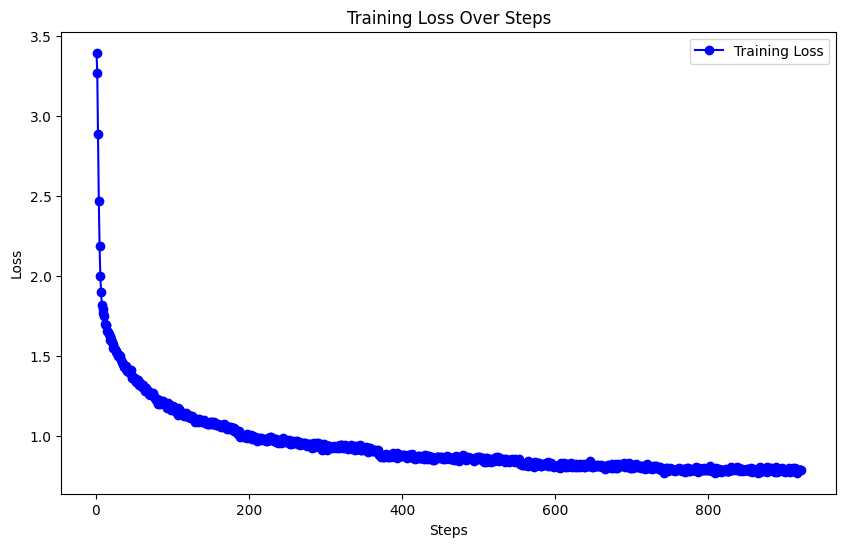

In [ ]:
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
steps = range(1, len(training_loss) + 1)  # Correcting this to reflect steps rather than epochs

plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, 'bo-', label='Training Loss')  # Plotting against steps now

plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()